# **Stolen Base Probability Sklearn**


## **Table of Contents**

- **[Imports](#Imports)** - Project imports
- **[Globals](#Globals)** - Global arguments for learning
- **[Utils](#Utils)** - Helper functions for training and analysis
- **[Data Preparation](#Data-Preparation)** - Data cleaning and feature engineering
- **[Gradient Boosting Classifier](#Gradient-Boosting-Classifier)** - Stolen base prediction based on Gradient Boosting Classifier
- **[Random Forest Classifier](#Random-Forest-Classifier)** - Stolen base prediction based on Random Forest Classifier
- **[XGBoost Classifier](#XGBoost-Classifier)** - Stolen base prediction based on XGBoost Classifier
- **[Evaluation](#Evaluation)** - Results from the three models

## **Imports**

In [ ]:
!pip install pybaseball
!pip install tabulate
!pip install optuna

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from tabulate import tabulate

from tqdm import tqdm, trange

from pybaseball import statcast_sprint_speed

from itertools import product

from joblib import Parallel, delayed

import optuna

from xgboost import XGBClassifier

from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_curve, f1_score, log_loss, accuracy_score, brier_score_loss
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.calibration import calibration_curve

from imblearn.over_sampling import SMOTE

## **Globals**

In [ ]:
PATH = "drive/MyDrive/stolen_bases/"

# Reduce sprint speed to 95% to simulate acceleration lag
ACCEL_PENALTY = 0.95

DISTANCE_COLUMNS = {i: f'seconds_since_hit_{i:03d}' for i in range(0, 95, 5)}

# Convert column names for access speed (optional if you access by name)
split_distances = np.array(sorted(DISTANCE_COLUMNS.keys()))

# Approximate velocity loss due to air drag (in mph)
VELO_LOSS = 2.0

# Average players reaction time
REACTION_TIME = 0.2  # 200 milliseconds

## **Utils**

In [ ]:
def calculate_runner_time(row):
    pid = row['runner_id']
    dist = row['distance_to_target']
    sprint_speed = row.get('sprint_speed')

    # Handle missing data
    if pd.isna(pid) or pd.isna(dist) or pd.isna(sprint_speed):
        return np.nan

    # Find closest lower split
    available_dists = split_distances[split_distances <= dist]
    if len(available_dists) == 0:
        return dist / sprint_speed

    split_ft = max(available_dists)
    split_col = DISTANCE_COLUMNS[split_ft]

    try:
        player_row = player_speed_df.loc[pid]
        split_time = player_row[split_col]
    except KeyError:
        return dist / sprint_speed

    remaining = dist - split_ft
    total_time = split_time + (remaining / sprint_speed)
    return total_time

def create_results(
    X_test,
    y_test,
    y_pred,
    y_pred_proba,
    feature_cols,
    results_file
):

    df = X_test.copy()

    df['y_test'] = y_test.apply(lambda x: 'SB' if x == 1 else 'CS')
    df['y_pred'] = ['SB' if x == 1 else 'CS' for x in y_pred]

    df['missclassified'] = df['y_test'] != df['y_pred']
    df['prediction_confidence'] = np.max(y_pred_proba)

    pitch_columns = [
        'pitch_CH', 'pitch_CS', 'pitch_CU', 'pitch_EP', 'pitch_FC', 'pitch_FF', 'pitch_FO',
        'pitch_FS', 'pitch_KC', 'pitch_KN', 'pitch_PO', 'pitch_SC', 'pitch_SI', 'pitch_SL',
        'pitch_ST', 'pitch_SV'
    ]

    df['pitch_type'] = df[pitch_columns].idxmax(axis=1)

    df['pitch_type'] = df['pitch_type'].str.replace('pitch_', '', regex=False)

    df = df.sort_values(by='missclassified')

    feature_cols = X_test.columns.tolist()

    df = df.merge(
        data[feature_cols + ['description', 'video_link']],
        on=feature_cols,
        how='left'  # only keep rows from inputs_df
    )

    df.drop(columns=pitch_columns, inplace=True)

    df.to_csv(f'{PATH}data/{results_file}.csv', index=False)

    pd.set_option('display.max_rows', 100)
    pd.set_option('display.max_columns', 100)

    display(df)

def create_calibration_plot(
    y_test,
    y_pred_proba
):
    prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy='quantile')
    brier_score = brier_score_loss(y_test, y_pred_proba)

    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel("Predicted Probability")
    plt.ylabel("Observed Frequency")
    plt.title(f"Calibration Plot\nBrier Score: {brier_score}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_model_misclassification_pies(
    model_df,
    model_name="Model"
):
    total_samples = len(model_df)
    misclassified_df = model_df[model_df["missclassified"] == True]
    correct_count = total_samples - len(misclassified_df)
    misclassified_count = len(misclassified_df)
    colors = ['#1f77b4', '#ff7f0e']

    # Left pie: Correct vs Misclassified
    left_labels = ["Correct", "Misclassified"]
    left_sizes = [correct_count, misclassified_count]

    # Right pie: SB vs CS (in misclassified only)
    class_counts = misclassified_df["y_test"].value_counts().reindex(["SB", "CS"], fill_value=0)
    right_labels = class_counts.index.tolist()
    right_sizes = class_counts.values.tolist()

    def autopct_with_count(values):
        def func(pct):
            total = sum(values)
            count = int(round(pct * total / 100.0))
            return f'{pct:.1f}%\n({count})'
        return func

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"{model_name} Misclassification Breakdown", fontsize=16, weight='bold', y=1.05)

    # Left pie: correct vs misclassified
    wedges1, texts1, autotexts1 = ax1.pie(
        left_sizes,
        labels=left_labels,
        autopct=autopct_with_count(left_sizes),
        startangle=90,
        colors=colors,
        explode=(0.05, 0),
        wedgeprops={'edgecolor': 'white'},
        textprops={'fontsize': 10}
    )
    ax1.set_title("Correct vs Misclassified", fontsize=12, pad=20)

    # Right pie: SB vs CS in misclassified
    wedges2, texts2, autotexts2 = ax2.pie(
        right_sizes,
        labels=right_labels,
        autopct=autopct_with_count(right_sizes),
        startangle=90,
        colors=colors,
        explode=(0.05, 0),
        wedgeprops={'edgecolor': 'white'},
        textprops={'fontsize': 10}
    )
    ax2.set_title("Misclassified Class Distribution", fontsize=12, pad=20)

    plt.tight_layout(rect=[0, 0, 1, .99])  # Leave room for suptitle
    plt.show()


def plot_feature_importance_table(
    importance_series,
    model_name,
    title="Feature Importance",
    bar_color='gray'
):
    importance_series = importance_series.sort_values(ascending=False)
    importance_percent = (importance_series / importance_series.sum()) * 100
    importance_df = pd.DataFrame({
        "Feature": importance_percent.index,
        "Importance (%)": importance_percent.values.round(2)
    })

    table_data = importance_df.values.tolist()
    column_labels = importance_df.columns.tolist()
    n_rows = len(table_data)
    n_cols = len(column_labels)
    row_colors = [['lightgray'] * n_cols if i % 2 == 0 else ['white'] * n_cols for i in range(n_rows)]

    fig, (ax_table, ax_bar) = plt.subplots(1, 2, figsize=(14, 8), gridspec_kw={'width_ratios': [1, 2]})
    fig.suptitle(model_name, fontsize=16, weight='bold', y=1.02)
    ax_table.axis('off')

    table = ax_table.table(
        cellText=table_data,
        colLabels=column_labels,
        cellColours=row_colors,
        loc='center',
        cellLoc='left',
        colLoc='left'
    )

    table.scale(1, 1.5)
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    n_rows = len(table_data)
    n_cols = len(column_labels)

    for c in table.get_children():
        c.set_edgecolor('none')

    importance_percent[::-1].plot(kind='barh', ax=ax_bar, color=bar_color)
    ax_bar.set_title(title)
    ax_bar.set_xlabel("Importance (%)")
    ax_bar.set_ylabel("Feature")
    ax_bar.grid(axis='x', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()


## **Data Preparation**

In [ ]:
# Load data
data = pd.read_csv(f'{PATH}data/sb_data_2016-2025.csv')

# Players 90ft splits df
player_splits_df = pd.read_csv(f'{PATH}data/running_splits.csv')

# Players speed df
player_speed_df = pd.read_csv(f'{PATH}data/player_speed.csv')

# Pop time df
pop_time_df = pd.read_csv(f'{PATH}data/pop_time.csv')

# Add runners speed
data = data.merge(player_speed_df, on='runner_id', how='left')

# Add pop time based on target base
data = data.merge(pop_time_df, on=['target_base', 'catcher_id'], how='left')

# Time for the runner to target base
data ['distance_to_target'] = (90 - data['at_pitch_release'] )

data['runner_to_target'] = data.apply(calculate_runner_time, axis=1) + REACTION_TIME

# Calculate average velocity in ft/s accounting for air resistance
data['avg_velo'] = ((data['velo'] + (data['velo'] - VELO_LOSS)) / 2) * 1.46667

# Time from mound to home using average velocity
data['mound_to_home'] = 60.5 / data['avg_velo']

# Binary result
data['result'] = data['result'].apply(lambda x: 1 if x == 'SB' else 0)

# Time it takes the ball to reach target_base
data['ball_to_target'] = data['mound_to_home'] + data['pop_time'] + (2 * REACTION_TIME)

# Calculated outcome of success
data['time_margin'] = data['ball_to_target'] - data['runner_to_target']
data['runner_safe'] = data['time_margin'] > 0  # if True, runner likely beat the throw

# KNNImputer fill missing pop times
base_map = {'2B': 2, '3B': 3}

data['target_base_num'] = data['target_base'].map(base_map)

features_for_imputation = ['pop_time', 'avg_velo', 'at_pitch_release', 'target_base_num', 'mound_to_home']

imputer = KNNImputer(n_neighbors=5)

imputed_data = imputer.fit_transform(data[features_for_imputation])

data['pop_time'] = imputed_data[:, features_for_imputation.index('pop_time')]

# One-hot encode pitch_type
pitch_dummies = pd.get_dummies(data['pitch_type'], prefix='pitch')

# Target base
data['target_base'] = data['target_base'].apply(lambda x: 2 if x == '2B' else 3)

# Remove base columns
data = data.drop(columns=[
        'date',
        'catcher_id',
        'pitcher_id',
        'runner_id',
        'batter_id',
        'fielder_id',
        'runner_stealing_runs',
        'lead_distance_gained',
        'at_pitchers_first_move',
        'distance_to_target',
        'mound_to_home',
        'target_base',
        'velo',
        'pitch_type',
        'match_up'
        ])

# Add pitch type
data = pd.concat([data, pitch_dummies], axis=1)

# Remove nan
data = data.dropna()

# Remove input columns
X = data.drop(columns=['result', 'description', 'video_link'])

# Input features
input_features = X.columns.tolist()
print("Input Features:")
for input in input_features:
  if not 'pitch_' in input:
    print("   - " + str(input))

# Ouputs
y = data['result']

# Train/Test Splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Input Features:
   - ball_count
   - strike_count
   - sprint_speed
   - pop_time
   - runner_to_target
   - avg_velo
   - ball_to_target
   - time_margin
   - runner_safe
   - target_base_num


## **Gradient Boosting Classifier**

### **Hyperparameter Optimization**

In [ ]:
def objective(trial):
    param_space = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 250, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', range(1, len(X.columns))),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0)
    }

    gb_model = GradientBoostingClassifier(
        **param_space,
        validation_fraction=0.1,
        n_iter_no_change=5,
        random_state=42
    )

    gb_model.fit(
        X_train,
        y_train
    )

    y_pred_proba = gb_model.predict_proba(X_test)

    loss = log_loss(y_test, y_pred_proba)

    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params_optuna = study.best_params

### **Final Boosting Model**

In [ ]:
final_boosting_model = GradientBoostingClassifier(
    **best_params_optuna,
    validation_fraction=0.1,
    n_iter_no_change=5,
    random_state=4
)

final_boosting_model.fit(X_train, y_train)

# Evaluate
y_pred = final_boosting_model.predict(X_test)
y_pred_proba = final_boosting_model.predict_proba(X_test)[:, 1]
accuracy_best_optuna = accuracy_score(y_test, y_pred)
logloss_best_optuna = log_loss(y_test, y_pred_proba)

# Output
print(f"Best Parameters (Optuna): {best_params_optuna}")
print(f"Best Model Accuracy: {accuracy_best_optuna:.4f}")
print(f"Best Model Log Loss: {logloss_best_optuna:.4f}")
print(classification_report(y_test, y_pred))

Best Parameters (Optuna): {'n_estimators': 200, 'learning_rate': 0.05481159584986882, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 10, 'max_features': 9, 'subsample': 0.6621078443229225}
Best Model Accuracy: 0.8070
Best Model Log Loss: 0.4170
              precision    recall  f1-score   support

           0       0.56      0.18      0.27       358
           1       0.82      0.97      0.89      1430

    accuracy                           0.81      1788
   macro avg       0.69      0.57      0.58      1788
weighted avg       0.77      0.81      0.76      1788



### **Results**

In [ ]:
create_results(
    X_test,
    y_test,
    y_pred,
    y_pred_proba,
    input_features,
    'gb_results'
)

,at_pitch_release,ball_count,strike_count,sprint_speed,pop_time,runner_to_target,avg_velo,ball_to_target,time_margin,runner_safe,target_base_num,y_test,y_pred,missclassified,prediction_confidence,pitch_type,description,video_link
0,24.6,1,0,27.2,2.000,2.604412,124.226949,2.887012,0.282600,True,2,SB,SB,False,0.981245,CU,Tommy Nance Foul Tip to Yadiel Hernandez,https://baseballsavant.mlb.com/sporty-videos?p...
1,30.2,1,0,28.7,1.480,2.283624,124.226949,2.367012,0.083388,True,3,SB,SB,False,0.981245,SL,Josh Hader Called Strike to Nick Fortes,https://baseballsavant.mlb.com/sporty-videos?p...
2,21.7,1,2,29.1,1.982,2.547079,128.333625,2.853428,0.306348,True,2,SB,SB,False,0.981245,CH,Kyle Schwarber strikes out swinging. Matt Vier...,https://baseballsavant.mlb.com/sporty-videos?p...
3,32.2,1,1,28.6,1.513,2.220979,140.946987,2.342239,0.121260,True,3,SB,SB,False,0.981245,FF,Bryan Abreu Ball to Yandy Díaz,https://baseballsavant.mlb.com/sporty-videos?p...
4,32.9,0,1,28.5,1.551,2.203509,121.293609,2.449790,0.246281,True,3,SB,SB,False,0.981245,CH,Steven Matz Ball to Thairo Estrada,https://baseballsavant.mlb.com/sporty-videos?p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,17.7,1,2,27.7,2.027,2.810108,132.586968,2.883304,0.073196,True,2,CS,SB,True,0.981245,SI,Zach Neto caught stealing 2nd base| catcher Mi...,https://baseballsavant.mlb.com/sporty-videos?p...
1795,21.6,0,0,27.1,2.013,2.723985,110.000250,2.962999,0.239014,True,2,CS,SB,True,0.981245,CU,Hunter Renfroe caught stealing 2nd base| catch...,https://baseballsavant.mlb.com/sporty-videos?p...
1796,21.8,1,0,28.4,2.027,2.601408,136.546977,2.870071,0.268663,True,2,CS,SB,True,0.981245,FF,Bryce Miller Ball to Jung Hoo Lee,https://baseballsavant.mlb.com/sporty-videos?p...
1797,19.2,1,0,28.3,2.032,2.701767,128.480292,2.902889,0.201123,True,2,CS,SB,True,0.981245,FC,Shohei Ohtani caught stealing 2nd base| catche...,https://baseballsavant.mlb.com/sporty-videos?p...


### **Calibration Plot**

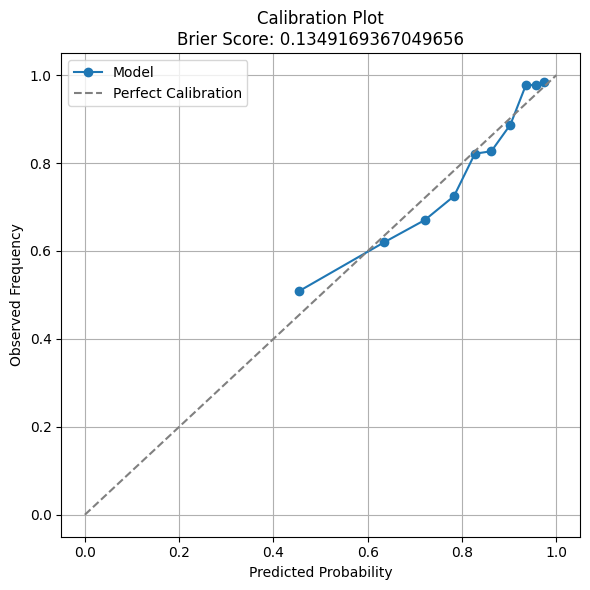

In [ ]:
create_calibration_plot(y_test, y_pred_proba)

## **Random Forest Classifier**

### **Hyperparameter Optimization**

In [ ]:
def objective(trial):
    param_space = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 250, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', range(1, len(X.columns))),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    rf_model = RandomForestClassifier(
        **param_space,
        random_state=42
    )

    rf_model.fit(X_train, y_train)

    y_pred_proba = rf_model.predict_proba(X_test)

    # Cross-entropy loss
    loss = log_loss(y_test, y_pred_proba)

    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params_optuna = study.best_params

### **Final Random Forest Model**

In [ ]:
final_rf_model = RandomForestClassifier(
    **best_params_optuna,
    random_state=42
)

final_rf_model.fit(X_train, y_train)

# Evaluate
y_pred = final_rf_model.predict(X_test)
y_pred_proba = final_rf_model.predict_proba(X_test)[:, 1]
accuracy_best_optuna = accuracy_score(y_test, y_pred)
logloss_best_optuna = log_loss(y_test, y_pred_proba)

# Output
print(f"Best Parameters (Optuna): {best_params_optuna}")
print(f"Best Model Accuracy: {accuracy_best_optuna:.4f}")
print(f"Best Model Log Loss: {logloss_best_optuna:.4f}")
print(classification_report(y_test, y_pred))

Best Parameters (Optuna): {'n_estimators': 50, 'max_depth': 7, 'min_samples_split': 9, 'min_samples_leaf': 10, 'max_features': 18, 'bootstrap': True}
Best Model Accuracy: 0.8115
Best Model Log Loss: 0.4157
              precision    recall  f1-score   support

           0       0.61      0.17      0.26       358
           1       0.82      0.97      0.89      1430

    accuracy                           0.81      1788
   macro avg       0.71      0.57      0.58      1788
weighted avg       0.78      0.81      0.77      1788



### **Results**

In [ ]:
create_results(
    X_test,
    y_test,
    y_pred,
    y_pred_proba,
    input_features,
    'rf_results'
)

,at_pitch_release,ball_count,strike_count,sprint_speed,pop_time,runner_to_target,avg_velo,ball_to_target,time_margin,runner_safe,target_base_num,y_test,y_pred,missclassified,prediction_confidence,pitch_type,description,video_link
0,24.6,1,0,27.2,2.000,2.604412,124.226949,2.887012,0.282600,True,2,SB,SB,False,0.999653,CU,Tommy Nance Foul Tip to Yadiel Hernandez,https://baseballsavant.mlb.com/sporty-videos?p...
1,37.8,1,0,29.6,1.610,1.963514,143.880327,2.430488,0.466975,True,3,SB,SB,False,0.999653,FF,Aroldis Chapman Ball to Matt Olson,https://baseballsavant.mlb.com/sporty-videos?p...
2,18.8,1,2,28.4,1.982,2.707042,136.546977,2.825071,0.118029,True,2,CS,CS,False,0.999653,SI,Lane Thomas called out on strikes and Alex Cal...,https://baseballsavant.mlb.com/sporty-videos?p...
3,20.3,2,2,28.0,1.968,2.689286,138.013647,2.806362,0.117077,True,2,CS,CS,False,0.999653,FF,Mariners challenged (tag play)| call on the fi...,https://baseballsavant.mlb.com/sporty-videos?p...
4,30.2,1,0,28.7,1.480,2.283624,124.226949,2.367012,0.083388,True,3,SB,SB,False,0.999653,SL,Josh Hader Called Strike to Nick Fortes,https://baseballsavant.mlb.com/sporty-videos?p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,21.6,0,0,27.1,2.013,2.723985,110.000250,2.962999,0.239014,True,2,CS,SB,True,0.999653,CU,Hunter Renfroe caught stealing 2nd base| catch...,https://baseballsavant.mlb.com/sporty-videos?p...
1795,21.4,3,2,27.8,1.926,2.667626,136.546977,2.769071,0.101445,True,2,CS,SB,True,0.999653,SI,Jacob Stallings strikes out on a foul tip and ...,https://baseballsavant.mlb.com/sporty-videos?p...
1796,23.0,0,0,28.8,1.935,2.526389,122.906946,2.827242,0.300853,True,2,CS,SB,True,0.999653,SL,Bryan Baker Ball to Myles Straw,https://baseballsavant.mlb.com/sporty-videos?p...
1797,15.3,1,2,29.4,1.934,2.740816,121.293609,2.832790,0.091973,True,2,SB,CS,True,0.999653,SL,Mason Englert Ball to Jose Caballero,https://baseballsavant.mlb.com/sporty-videos?p...


### **Calibration Plot**

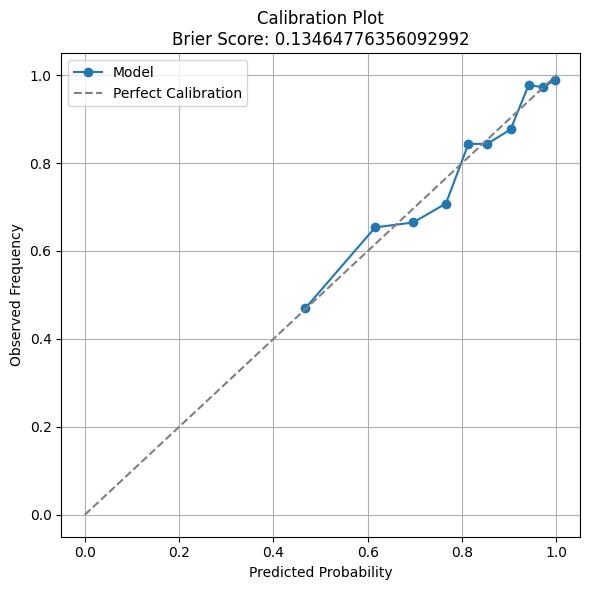

In [ ]:
create_calibration_plot(y_test, y_pred_proba)

## **XGBoost Classifier**

### **Hyperparameter Optimization**

In [ ]:
def objective(trial):
    param_space = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 250, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
    }

    xgb_model = XGBClassifier(
        **param_space,
        random_state=42
    )

    xgb_model.fit(X_train, y_train)
    y_pred_proba = xgb_model.predict_proba(X_test)

    # Cross-entropy loss
    loss = log_loss(y_test, y_pred_proba)

    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params_optuna = study.best_params


### **Final XGBoost Model**

In [ ]:
final_xgboost_model = XGBClassifier(
    **best_params_optuna,
    random_state=42
)

final_xgboost_model.fit(X_train, y_train)

# Evaluate
y_pred = final_xgboost_model.predict(X_test)
y_pred_proba = final_xgboost_model.predict_proba(X_test)[:, 1]
accuracy_best_optuna = accuracy_score(y_test, y_pred)
logloss_best_optuna = log_loss(y_test, y_pred_proba)

# Output
print(f"Best Parameters (Optuna): {best_params_optuna}")
print(f"Best Model Accuracy: {accuracy_best_optuna:.4f}")
print(f"Best Model Log Loss: {logloss_best_optuna:.4f}")
print(classification_report(y_test, y_pred))

Best Parameters (Optuna): {'n_estimators': 100, 'learning_rate': 0.08568241041007078, 'max_depth': 3, 'min_child_weight': 1, 'gamma': 0.26238725286392045, 'subsample': 0.9098570733851, 'colsample_bytree': 0.5895981724521122, 'reg_alpha': 0.725489830418665, 'reg_lambda': 0.7718611190717086}
Best Model Accuracy: 0.8087
Best Model Log Loss: 0.4123
              precision    recall  f1-score   support

           0       0.57      0.17      0.27       358
           1       0.82      0.97      0.89      1430

    accuracy                           0.81      1788
   macro avg       0.70      0.57      0.58      1788
weighted avg       0.77      0.81      0.77      1788



### **Results**

In [ ]:
create_results(
    X_test,
    y_test,
    y_pred,
    y_pred_proba,
    input_features,
    'xgb_results'
)

,at_pitch_release,ball_count,strike_count,sprint_speed,pop_time,runner_to_target,avg_velo,ball_to_target,time_margin,runner_safe,target_base_num,y_test,y_pred,missclassified,prediction_confidence,pitch_type,description,video_link
0,24.6,1,0,27.2,2.000,2.604412,124.226949,2.887012,0.282600,True,2,SB,SB,False,0.997689,CU,Tommy Nance Foul Tip to Yadiel Hernandez,https://baseballsavant.mlb.com/sporty-videos?p...
1,18.8,1,2,28.4,1.982,2.707042,136.546977,2.825071,0.118029,True,2,CS,CS,False,0.997689,SI,Lane Thomas called out on strikes and Alex Cal...,https://baseballsavant.mlb.com/sporty-videos?p...
2,20.3,2,2,28.0,1.968,2.689286,138.013647,2.806362,0.117077,True,2,CS,CS,False,0.997689,FF,Mariners challenged (tag play)| call on the fi...,https://baseballsavant.mlb.com/sporty-videos?p...
3,30.2,1,0,28.7,1.480,2.283624,124.226949,2.367012,0.083388,True,3,SB,SB,False,0.997689,SL,Josh Hader Called Strike to Nick Fortes,https://baseballsavant.mlb.com/sporty-videos?p...
4,21.7,1,2,29.1,1.982,2.547079,128.333625,2.853428,0.306348,True,2,SB,SB,False,0.997689,CH,Kyle Schwarber strikes out swinging. Matt Vier...,https://baseballsavant.mlb.com/sporty-videos?p...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1794,17.7,1,2,27.7,2.027,2.810108,132.586968,2.883304,0.073196,True,2,CS,SB,True,0.997689,SI,Zach Neto caught stealing 2nd base| catcher Mi...,https://baseballsavant.mlb.com/sporty-videos?p...
1795,20.0,1,1,28.8,1.958,2.630556,131.853633,2.816842,0.186287,True,2,CS,SB,True,0.997689,FC,Gavin Lux caught stealing 2nd base| catcher Ya...,https://baseballsavant.mlb.com/sporty-videos?p...
1796,21.4,3,2,27.8,1.926,2.667626,136.546977,2.769071,0.101445,True,2,CS,SB,True,0.997689,SI,Jacob Stallings strikes out on a foul tip and ...,https://baseballsavant.mlb.com/sporty-videos?p...
1797,23.0,0,2,27.3,1.990,2.654212,134.200305,2.840819,0.186606,True,2,CS,SB,True,0.997689,FF,Connor Overton Ball to Jake Cave,https://baseballsavant.mlb.com/sporty-videos?p...


### **Calibration Plot**

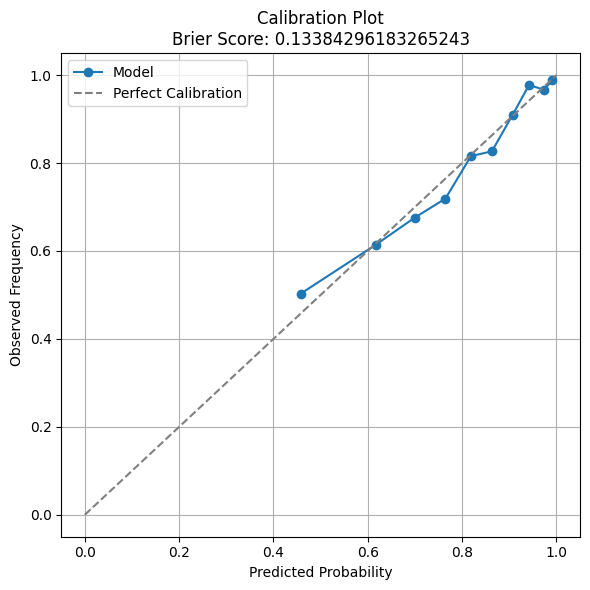

In [ ]:
create_calibration_plot(y_test, y_pred_proba)

## **Evaluation**

In [ ]:
# Results
boosting_df = pd.read_csv(f'{PATH}data/gb_results.csv')
rf_df = pd.read_csv(f'{PATH}data/rf_results.csv')
xgb_df = pd.read_csv(f'{PATH}data/xgb_results.csv')

### **Number of Misclassified**

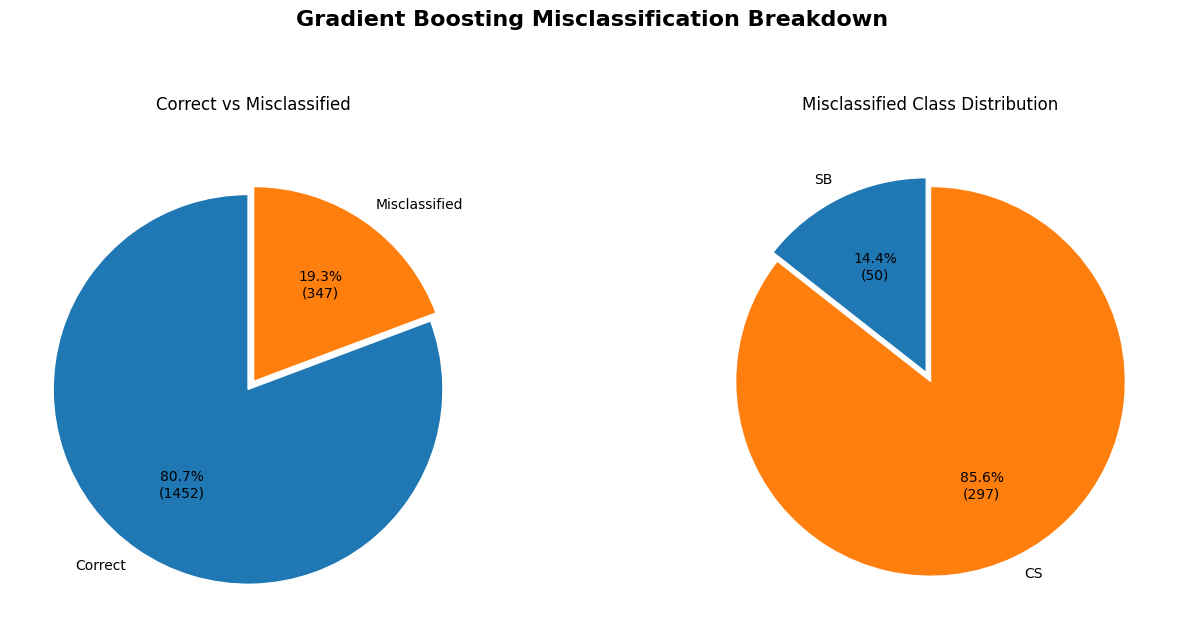

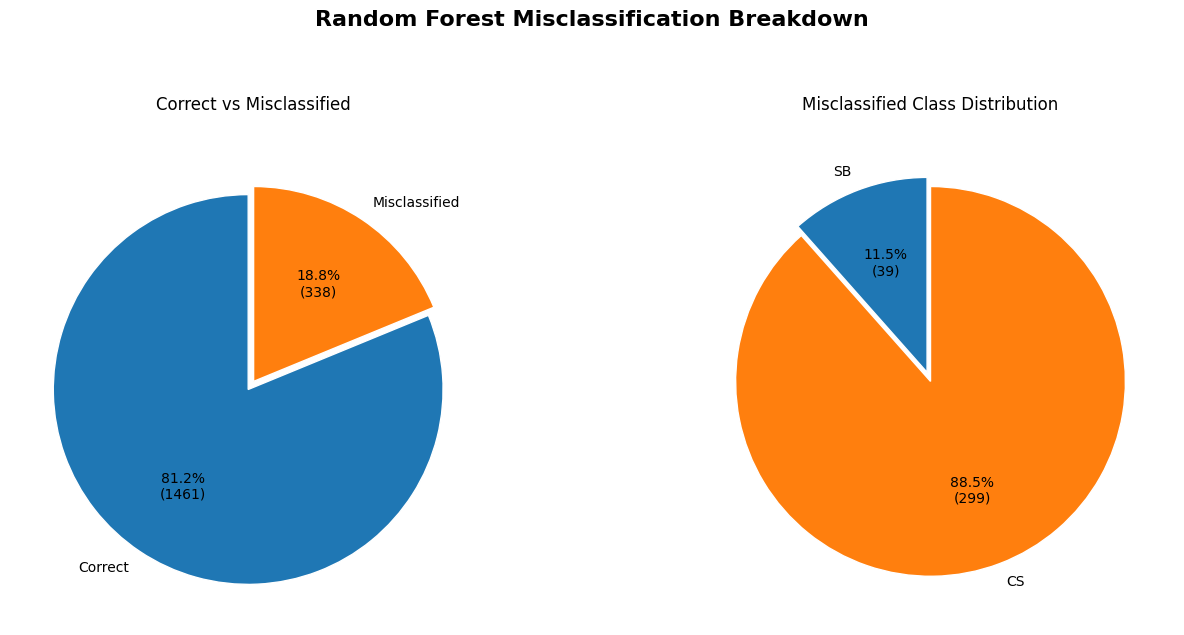

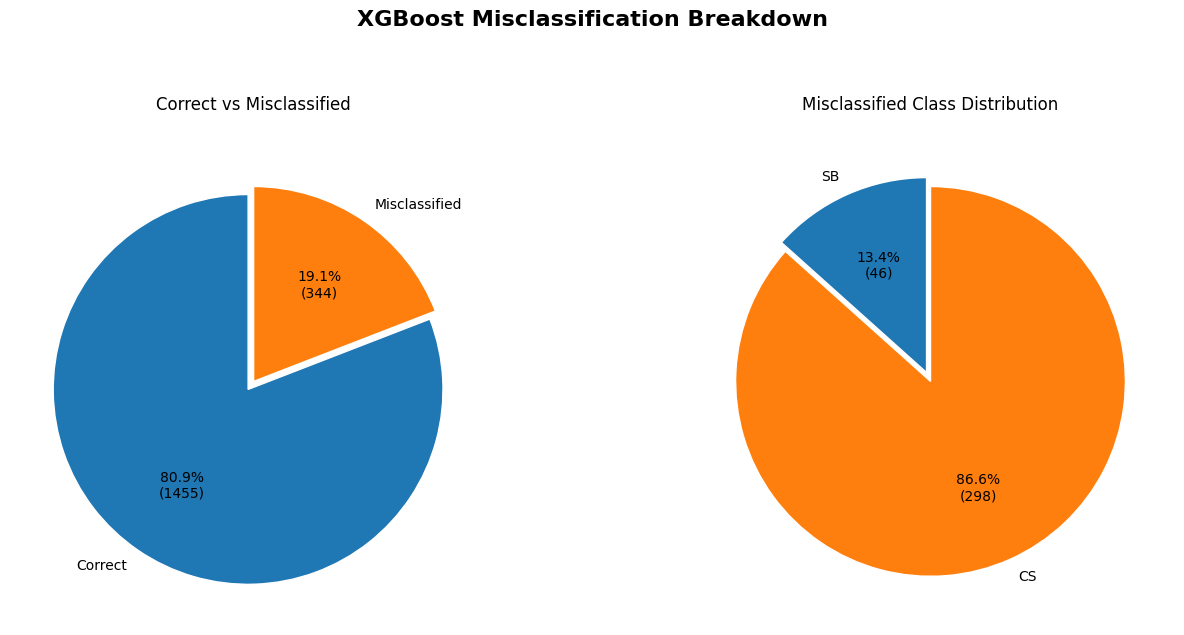

In [ ]:
plot_model_misclassification_pies(boosting_df, 'Gradient Boosting')
print()
plot_model_misclassification_pies(rf_df, 'Random Forest')
print()
plot_model_misclassification_pies(xgb_df, 'XGBoost')

### **Prepare Impactful Features**

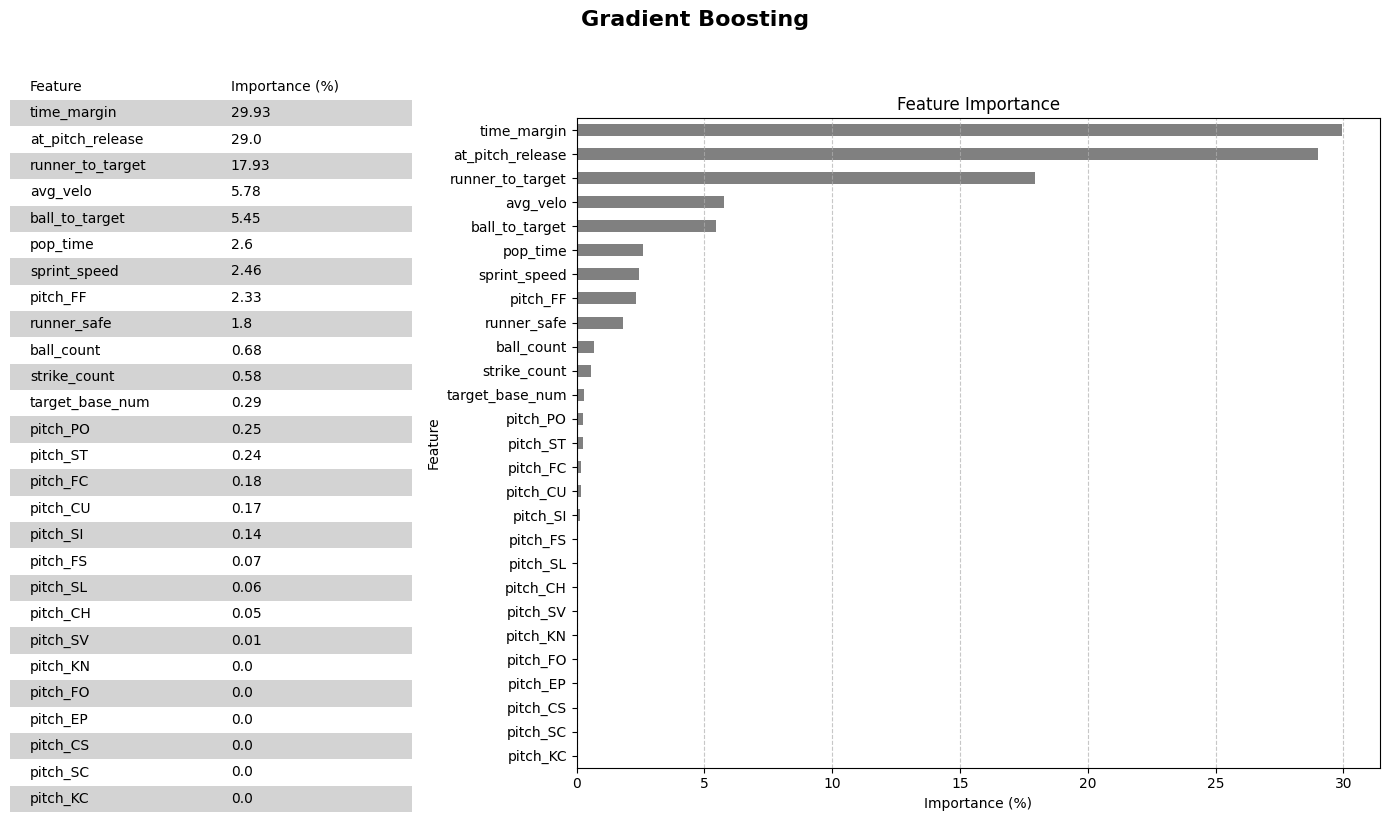

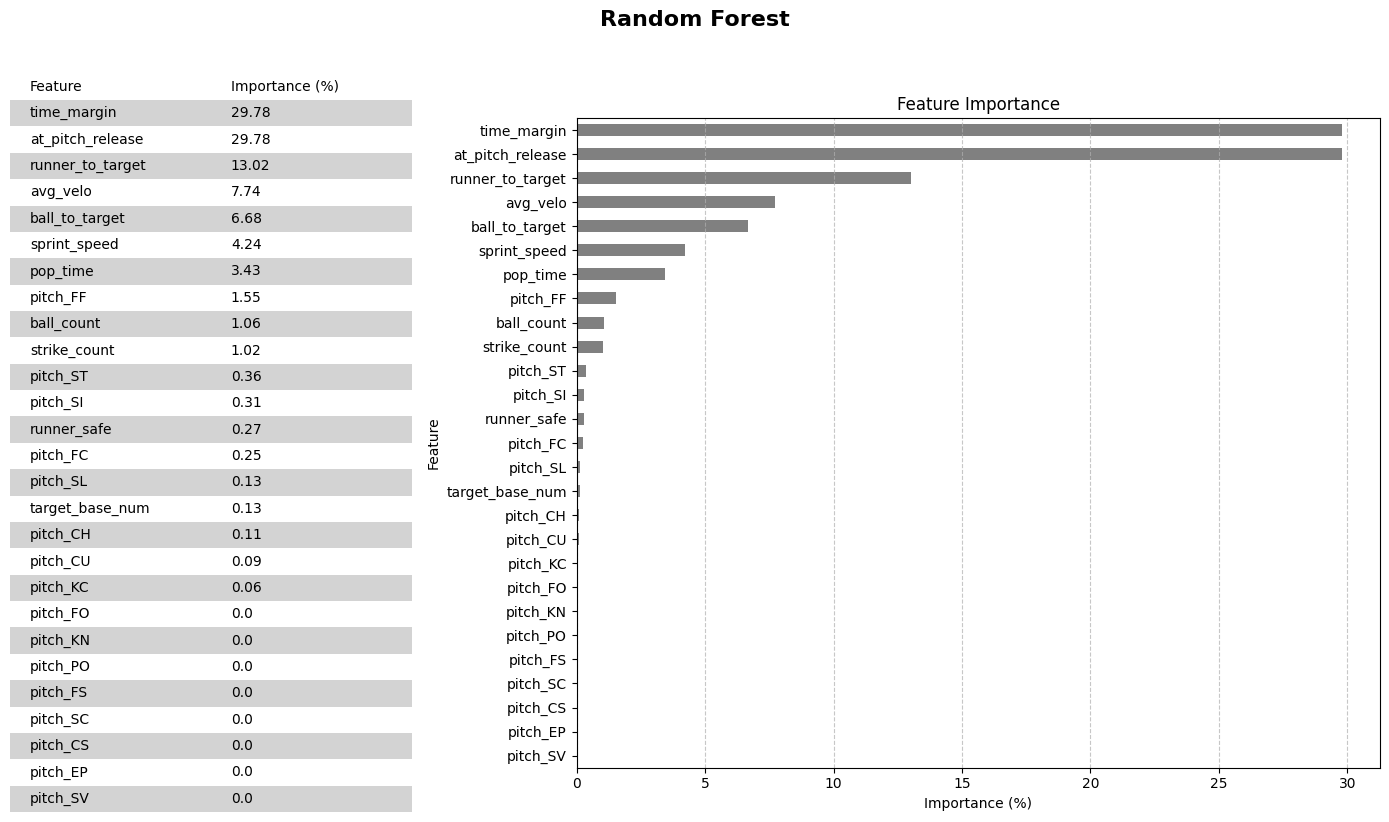

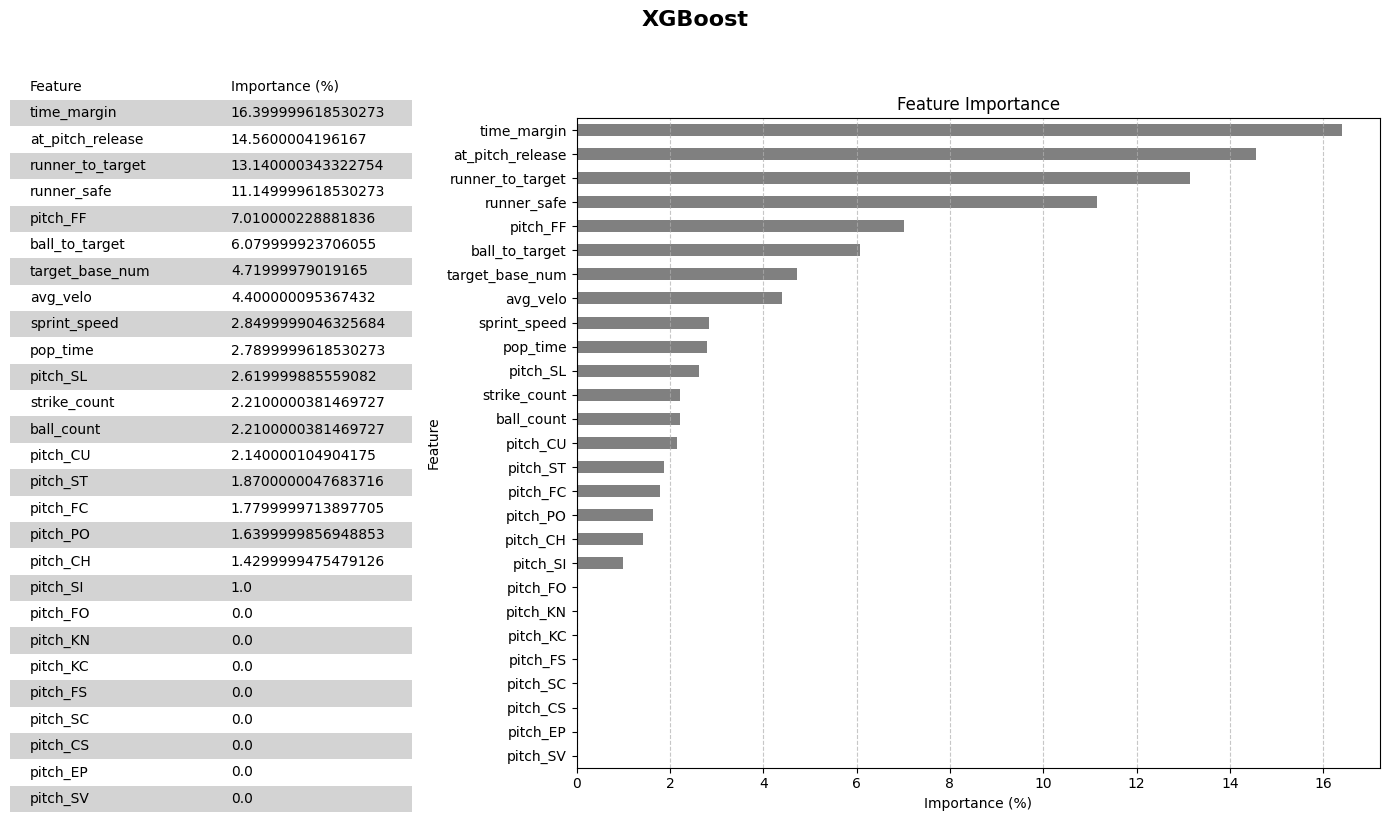

In [ ]:
features = X_test.columns.tolist()

boosting_importance = final_boosting_model.feature_importances_
rf_importance = final_rf_model.feature_importances_
xgb_importance = final_xgboost_model.feature_importances_

boosting_series = pd.Series(boosting_importance, index=features).sort_values()
rf_series = pd.Series(rf_importance, index=features).sort_values()
xgb_series = pd.Series(xgb_importance, index=features).sort_values()

plot_feature_importance_table(boosting_series, 'Gradient Boosting')
print()
plot_feature_importance_table(rf_series, 'Random Forest')
print()
plot_feature_importance_table(xgb_series, 'XGBoost')